In [8]:
from __future__ import division
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl

import warnings
warnings.filterwarnings('ignore')
np.random.seed(1234)

%matplotlib inline
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
if not os.path.isdir('DampedNewtonPreconditioning_images'):
    os.makedirs('DampedNewtonPreconditioning_images')

In [10]:
"""To compute distance matrix"""
def distmat(x,y):
    
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)

"""To Normalise a vector"""
normalize = lambda a: a/np.sum(a)

"""To Compute P"""
def GetP(u,K,v):
    return u*K*(v.T)

def plotp(x, col,plt, scale=200, edgecolors="k"):
  return plt.scatter(x[0,:], x[1,:], s=scale, edgecolors=edgecolors,  c=col, cmap='plasma', linewidths=2)

In [11]:
N=[400,500]

In [12]:
x=np.random.rand(2,N[0])-0.5
theta =2*np.pi*np.random.rand(1,N[1])
r=0.8+.2*np.random.rand(1,N[1])
y=np.vstack((r*np.cos(theta),r*np.sin(theta)))

In [13]:
import computational_OT

In [14]:
rho=0.95
c=0.05
DampedNewtonP=[]
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []

#epsilons=[0.05,0.08,0.1]
epsilons=[0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
#epsilons=[0.3]
for eps in epsilons:
    # Line Search
    print("Damped Newton for epsilon="+str(eps)+":")    
    #Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize(np.ones(N[0]))
    a=a.reshape(a.shape[0],-1)
    b = normalize(np.ones(N[1]))
    b=b.reshape(b.shape[0],-1)

    #Kernel
    K=np.exp(-C/eps)
    f,g=a,b

    print("Doing for (",N[0],N[1],").")
    print( " |- Iterating")  
    start=time.time()
    Optimizer=computational_OT.DampedNewton(K,a,b,f,g,eps,rho,c)
    out=Optimizer._update(maxiter=50)
    results_DampedNewton.append(out)
    end=time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P")
    
    DampedNewtonP.append(GetP(np.exp(out[0]/eps),K,np.exp(out[1]/eps)))
    print( " |- Recording (unstabilized) Hessian \n")

    mat  = -eps*Optimizer.Hessian
    diag = 1/np.sqrt( np.vstack( (a,b) ) ).flatten()
    mat = diag*mat*diag
    Hessians_DampedNewton.append( mat )


Damped Newton for epsilon=0.1:
Doing for ( 400 500 ).
 |- Iterating
Shape of u :  (1, 500, 1)
(500, 1)


ValueError: operands could not be broadcast together with shapes (400,400,500) (1,500,1) 

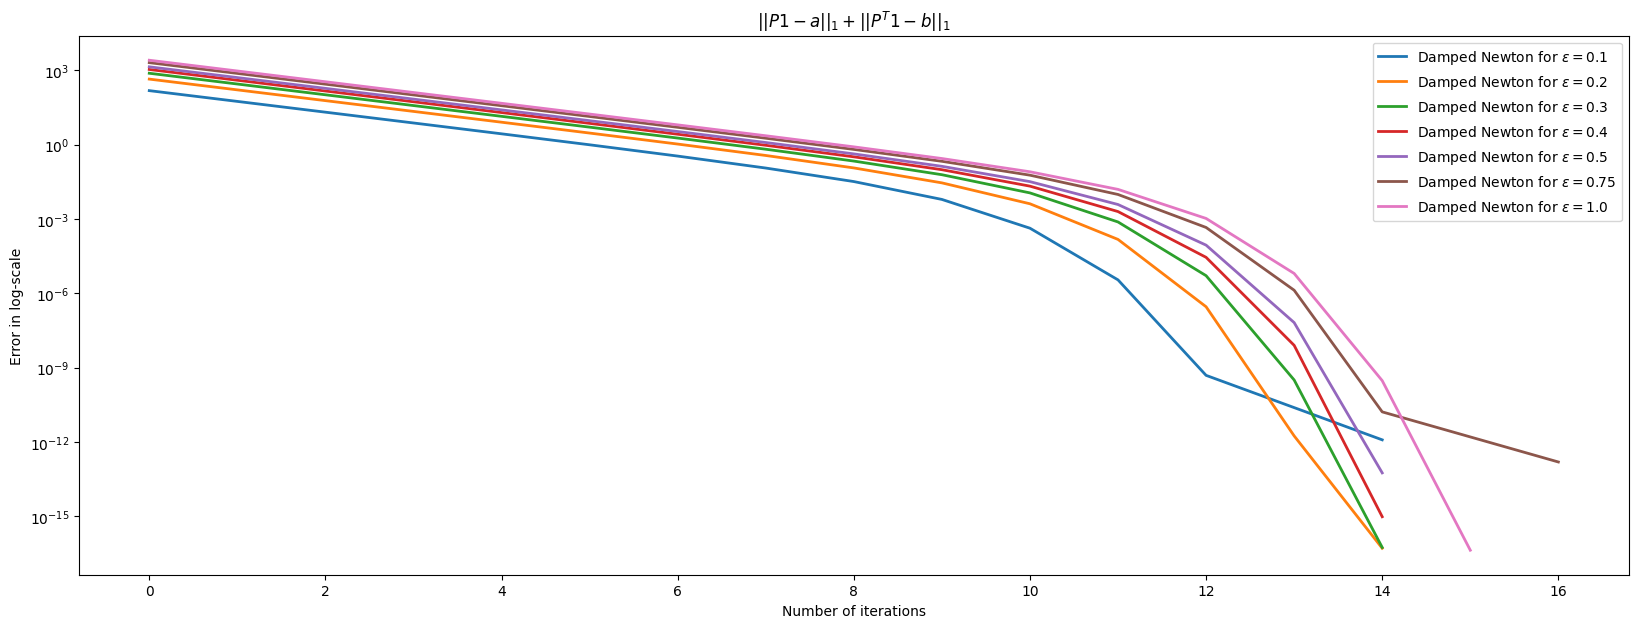


 Error plots can increase! The error is not the objective function!


In [ ]:
plt.figure(figsize = (20,7))
plt.title("$$")
plt.title("$||P1 -a||_1+||P^T 1 -b||_1$")

for i in range(len(results_DampedNewton)):
  error=np.asarray(results_DampedNewton[i][2])+np.asarray(results_DampedNewton[i][3])
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Error in log-scale")
plt.legend()
plt.yscale( 'log')
plt.savefig("DampedNewtonPreconditioning_images/ErrorLinesearchNewton.png")
plt.show()

print("\n Error plots can increase! The error is not the objective function!")

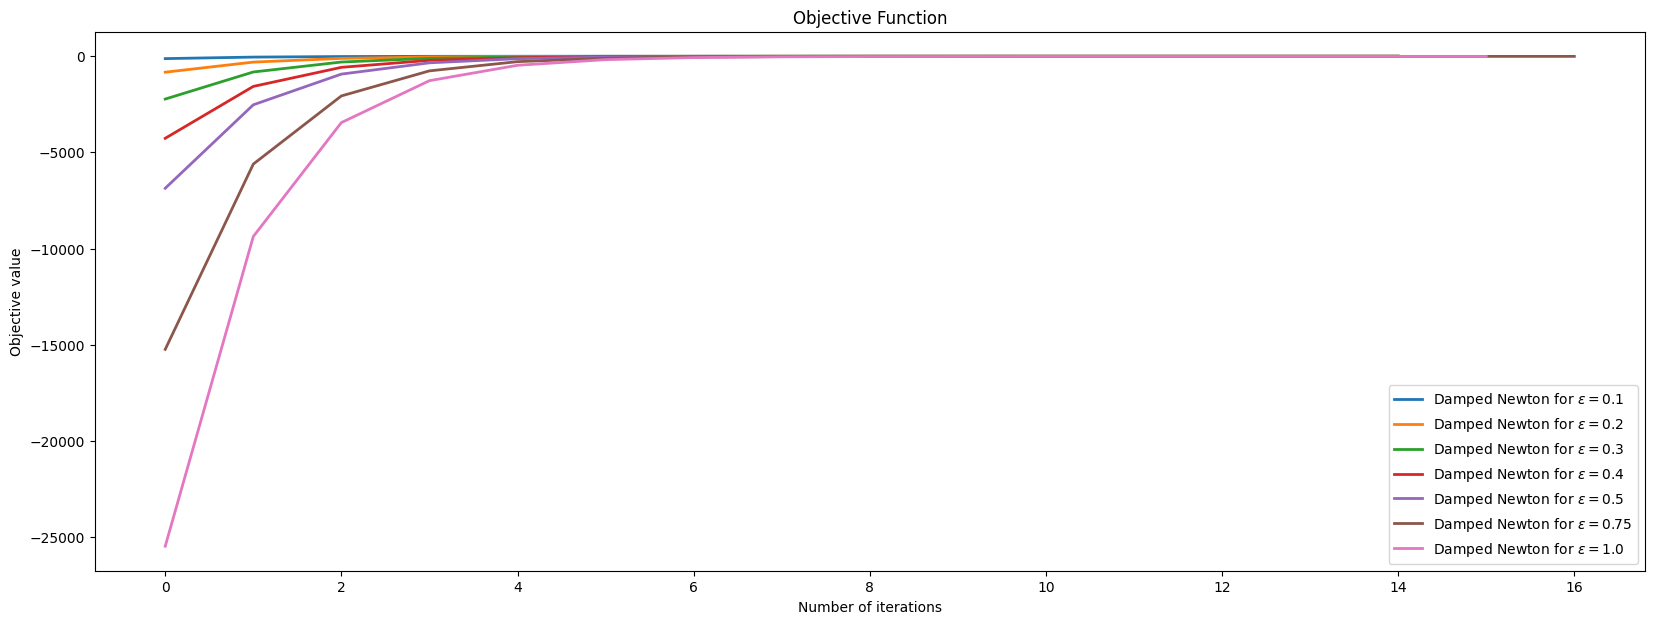

In [9]:
plt.figure(figsize = (20,7))
plt.title("$$")

plt.title("Objective Function")

for i in range(len(results_DampedNewton)):
  plt.plot( np.asarray(results_DampedNewton[i][4]),label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Objective value")
plt.legend()
plt.savefig("DampedNewtonPreconditioning_images/ObjectiveLineSearchNewton.png")
plt.show()


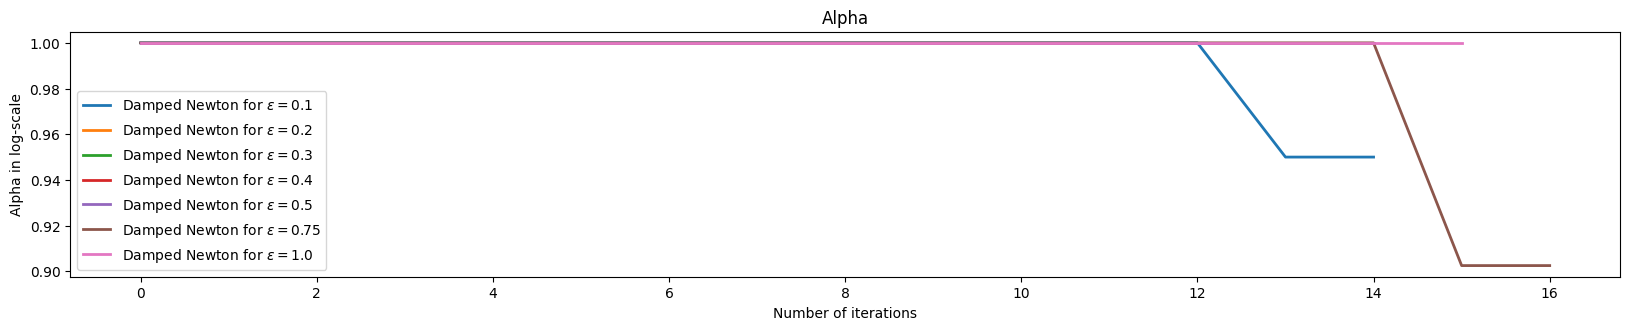

In [10]:
plt.figure(figsize = (20,7))
plt.subplot(2,1,1),
plt.title("Alpha")

for i in range(len(results_DampedNewton)):
  plt.plot( np.asarray(results_DampedNewton[i][5]),label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Alpha in log-scale")
plt.legend()
# plt.yscale( 'log')
plt.savefig("DampedNewtonPreconditioning_images/AlphaLineSearchNewton.png")
plt.show()



# I. Plotting spectrum as a function of $\varepsilon$

In [11]:
def spectral_decomposition(mat):
    eig, v = np.linalg.eigh( mat )
    sorting_indices = np.argsort(eig)
    eig = eig[sorting_indices]
    v   = v[:, sorting_indices]
    
    print( "List of smallest eigenvalues: ", eig[:10])
    print( "List of largest  eigenvalues: ", eig[-10:])

    return eig,v

In [12]:
eigs=[]
eigvecs=[]
for i in range(len(epsilons)):
    eps = epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    ev=spectral_decomposition( Hessians_DampedNewton[i] )
    eigs.append(ev[0])
    eigvecs.append(ev[1])
    print("")


Spectral statistics of Hessian for epsilon=0.1
List of smallest eigenvalues:  [-1.79801795e-16  9.03053723e-02  1.00036283e-01  2.52529832e-01
  3.35915328e-01  4.96446704e-01  5.15708340e-01  6.49741281e-01
  7.06676696e-01  7.98009761e-01]
List of largest  eigenvalues:  [1.20199024 1.2933233  1.35025872 1.48429166 1.5035533  1.66408467
 1.74747017 1.89996372 1.90969463 2.        ]

Spectral statistics of Hessian for epsilon=0.2
List of smallest eigenvalues:  [-6.50738145e-16  1.81236454e-01  1.98751814e-01  4.37004761e-01
  5.48066881e-01  7.31690411e-01  7.39458099e-01  8.54454594e-01
  8.91637245e-01  9.31890087e-01]
List of largest  eigenvalues:  [1.06810991 1.10836276 1.14554541 1.2605419  1.26830959 1.45193312
 1.56299524 1.80124819 1.81876355 2.        ]

Spectral statistics of Hessian for epsilon=0.3
List of smallest eigenvalues:  [5.71374586e-16 2.68153747e-01 2.92576837e-01 5.75506045e-01
 6.84260789e-01 8.47521014e-01 8.51331790e-01 9.25780296e-01
 9.53697570e-01 9.63236499

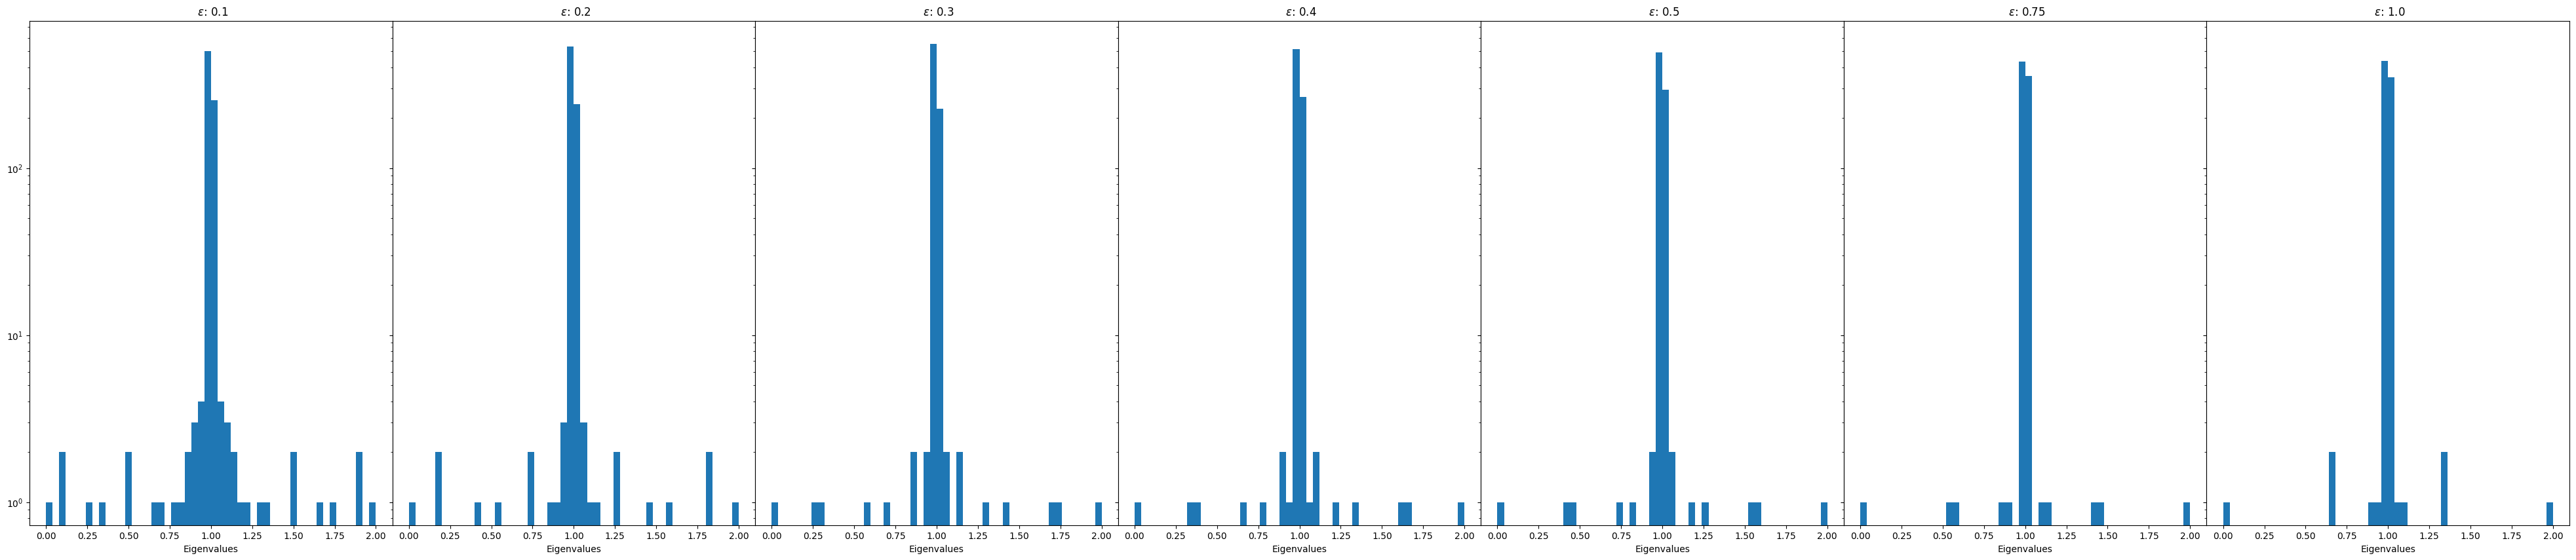

In [13]:
fig,ax=plt.subplots(figsize=(50,10),nrows=1, ncols=len(epsilons), sharey=True)
plt.title("Histogram of eigenvalues.")
for i in range(len(epsilons)):
    ax[i].hist( eigs[i], 50)
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]))
    ax[i].set_xlabel("Eigenvalues")
    ax[i].set_yscale( "log" )
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig("DampedNewtonPreconditioning_images/eigenhistunstabilized.png")
plt.show()

# II. Unstabilized vs stabilized Hessians

In [14]:
def build_preconditioners( modified_Hessian, ansatz=True ):
    # Diagonalize
    eigenvalues, eigenvectors = np.linalg.eigh( modified_Hessian )
    sorting_indices = np.argsort(eigenvalues)
    eigenvalues  = eigenvalues[sorting_indices]
    eigenvectors = eigenvectors[:, sorting_indices]
    # Form null vector
    if not ansatz:
        null_vector = eigenvectors[:, 0]
    else:
        null_vector = np.hstack( (np.ones(N[0]), -np.ones(N[1])) )
        norm = np.sqrt( N[0] + N[1] )
        null_vector = null_vector/norm
    # Form other vectors (only 7)
    n,m = eigenvectors.shape
    precond_vectors = eigenvectors[:, [m-1,1,m-2,2,m-3,3,m-4] ]
    precond_vectors = []
    for index in [m-1,1,m-2,2,m-3,3,m-4]:
        precond_vectors.append( eigenvectors[:,index] )
    #
    return null_vector, precond_vectors

In [15]:
def print_spectral_statistics_helper(mat):
    eig, v = np.linalg.eigh( mat )
    sorting_indices = np.argsort(eig)
    eig = eig[sorting_indices]
    v   = v[:, sorting_indices]
    #
    print( "List of smallest eigenvalues: ", eig[:5])
    print( "List of largest  eigenvalues: ", eig[-5:])
    min_index = np.argmin(eig)
    max_index = np.argmax(eig)
    min_value = eig[ min_index ]
    max_value = eig[max_index]
    min_vector = v[:, min_index]
    min_vector = min_vector/min_vector[0]
    max_vector = v[:,max_index]
    max_vector = max_vector/max_vector[0]
    condition_number = max_value/min_value
    print("Condition number: ", condition_number)
    return

def print_spectral_statistics_(mat, null_vector, precond_vectors):
    
    #
    print( "-- Without conditioning: " )
    print_spectral_statistics_helper(mat)
    
    #
    print( "-- Conditioning with null vector only: " )
    min_vector = null_vector
    min_vector = min_vector/np.linalg.norm(min_vector)
    min_vector = min_vector.reshape( (min_vector.shape[0], 1) )
    mat = mat + np.dot( min_vector, min_vector.T)
    print_spectral_statistics_helper(mat)

    #
    n,k = np.shape( precond_vectors )
    for i in range(k):
        vector = precond_vectors[:,i]
        value  = np.dot( np.dot( mat, vector ), vector)
        vector = vector.reshape( (vector.shape[0], 1) )
        P_matrix = np.identity(n) + (1/np.sqrt(value)-1)*np.dot( vector, vector.T)
        print( "-- Conditioning with ", i, " vectors")
        mat = np.dot( P_matrix, np.dot(mat, P_matrix) )
        print_spectral_statistics_helper(mat)
    # end for

    return

def print_spectral_statistics__(mat, null_vector, precond_vectors):
    
    #
    print( "-- Without conditioning: " )
    print_spectral_statistics_helper(mat)
    
    #
    print( "-- Conditioning with null vector only: " )
    min_vector = null_vector
    min_vector = min_vector/np.linalg.norm(min_vector)
    min_vector = min_vector.reshape( (min_vector.shape[0], 1) )
    mat = mat + np.dot( min_vector, min_vector.T)
    print_spectral_statistics_helper(mat)

    #
    n = len(null_vector)
    k = len( precond_vectors )
    for i in range(k):
        vector = precond_vectors[i]
        value  = np.dot( np.dot( mat, vector ), vector)
        vector = vector.reshape( (vector.shape[0], 1) )
        P_matrix = np.identity(n) + (1/np.sqrt(value)-1)*np.dot( vector, vector.T)
        print( "-- Conditioning with ", i+1, " vectors")
        mat = np.dot( P_matrix, np.dot(mat, P_matrix) )
        print_spectral_statistics_helper(mat)
    # end for

    return

In [16]:
# Using the largest epsilon's eigenvectors for conditioning
print( "Building preconditioning eigenvectors"  )
null_vector, precond_vectors = build_preconditioners( Hessians_DampedNewton[-1], ansatz=False )

for i in range(len(epsilons)):
    eps = epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    Hessian = Hessians_DampedNewton[i]
    print_spectral_statistics__( Hessian, null_vector, precond_vectors)
    print("")


Building preconditioning eigenvectors
Spectral statistics of Hessian for epsilon=0.1
-- Without conditioning: 
List of smallest eigenvalues:  [-1.79801795e-16  9.03053723e-02  1.00036283e-01  2.52529832e-01
  3.35915328e-01]
List of largest  eigenvalues:  [1.66408467 1.74747017 1.89996372 1.90969463 2.        ]
Condition number:  -1.1123359493767882e+16
-- Conditioning with null vector only: 
List of smallest eigenvalues:  [0.09030537 0.10003628 0.25252983 0.33591533 0.4964467 ]
List of largest  eigenvalues:  [1.66408467 1.74747017 1.89996372 1.90969463 2.        ]
Condition number:  22.147076629348568
-- Conditioning with  1  vectors
List of smallest eigenvalues:  [0.09030537 0.10003628 0.25252983 0.33591533 0.4964467 ]
List of largest  eigenvalues:  [1.5035533  1.66408467 1.74747017 1.89996372 1.90969463]
Condition number:  21.14707662979715
-- Conditioning with  2  vectors
List of smallest eigenvalues:  [0.09974144 0.25252518 0.33389276 0.49643682 0.4969885 ]
List of largest  eigenv

# III. Actual preconditioning

In [17]:
null_vector, precond_vectors = build_preconditioners( Hessians_DampedNewton[-1], ansatz=False )

In [18]:
rho=0.95
c=0.05
reset_starting_point=True
final_modified_Hessians = []
DampedNewtonP=[]
results_DampedNewton  = []
times_DampedNewton    = []

#epsilons=[0.05,0.08,0.1]
#precond_epsilons=[0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
precond_epsilons=[ 1.0, 0.75, 0.5, 0.4, 0.3, 0.1, 0.05]
#epsilons=[0.3]
f, g = None, None
for eps in precond_epsilons:
    # Line Search
    print("Damped Newton for epsilon="+str(eps)+":")    
    # Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize(np.ones(N[0]))
    a = a.reshape(a.shape[0],-1)
    b = normalize(np.ones(N[1]))
    b = b.reshape(b.shape[0],-1)

    #Kernel
    K=np.exp(-C/eps)

    if (f is None) or (g is None): 
        f,g=a,b

    print("Doing for (",N[0],N[1],").")
    print( " |- Iterating")  
    start=time.time()
    Optimizer=computational_OT.DampedNewton_With_Preconditioner(K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:])
    out=Optimizer._update(maxiter=50, iterative_inversion=30, timedebug=True,debug=False)
    results_DampedNewton.append(out)
    end=time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P")

    if not reset_starting_point:
        f = Optimizer.x[:a.shape[0]]
        g = Optimizer.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    
    DampedNewtonP.append(GetP(np.exp(out[0]/eps),K,np.exp(out[1]/eps)))
    final_modified_Hessians.append( Optimizer.modified_Hessian )


Damped Newton for epsilon=1.0:
Doing for ( 400 400 ).
 |- Iterating

 At iteration:  0

 Time required for preconditioning matrix formation:  3.11718 s.

 Time taken to debug:  0.0 s.

 Time taken to evaluate p_k:  0.11819 s.

 Time taken for unwinding:  0.01863 s.

 Time taken for the complete code block:  3.26 s.

 At iteration:  1

 Time required for preconditioning matrix formation:  3.25251 s.

 Time taken to debug:  0.0 s.

 Time taken to evaluate p_k:  0.15081 s.

 Time taken for unwinding:  0.0195 s.

 Time taken for the complete code block:  3.42 s.

 At iteration:  2

 Time required for preconditioning matrix formation:  3.04117 s.

 Time taken to debug:  0.0 s.

 Time taken to evaluate p_k:  0.03383 s.

 Time taken for unwinding:  0.01275 s.

 Time taken for the complete code block:  3.09 s.

 At iteration:  3

 Time required for preconditioning matrix formation:  3.1948 s.

 Time taken to debug:  0.0 s.

 Time taken to evaluate p_k:  0.17147 s.

 Time taken for unwinding:  

In [ ]:
plt.figure(figsize = (20,7))
plt.title("$$")
plt.title("$||P1 -a||_1+||P^T 1 -b||_1$")

for i in range(len(results_DampedNewton)):
  error=np.asarray(results_DampedNewton[i][2])+np.asarray(results_DampedNewton[i][3])
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Error in log-scale")
plt.legend()
plt.yscale( 'log')
plt.savefig("DampedNewtonPreconditioning_images/ErrorLinesearchNewton.png")
plt.show()

print("\n Error plots can increase! The error is not the objective function!")

In [ ]:
plt.figure(figsize = (20,7))
plt.title("$$")

plt.title("Minus the Objective Function")

for i in range(len(results_DampedNewton)):
  plt.plot( -np.asarray(results_DampedNewton[i][4]),label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Objective value")
plt.yscale('log')
plt.legend()
plt.savefig("DampedNewtonPreconditioning_images/ObjectiveLineSearchNewton.png")
plt.show()

In [ ]:
plt.figure(figsize = (20,7))
plt.subplot(2,1,1),
plt.title("Alpha")

for i in range(len(results_DampedNewton)):
  plt.plot( np.asarray(results_DampedNewton[i][5]),label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Alpha in log-scale")
plt.legend()
# plt.yscale( 'log')
plt.savefig("DampedNewtonPreconditioning_images/AlphaLineSearchNewton.png")
plt.show()


# IV. More spectral statistics

In [ ]:
# Using the largest epsilon's eigenvectors for conditioning
print( "Building preconditioning eigenvectors"  )
#null_vector, precond_vectors = build_preconditioners( Hessians_DampedNewton[-1], ansatz=False )
null_vector, precond_vectors = build_preconditioners( final_modified_Hessians[0], ansatz=False )

for i in range(len(precond_epsilons)):
    eps = precond_epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    Hessian = final_modified_Hessians[i]
    print_spectral_statistics__( Hessian, null_vector, precond_vectors)
    print("")

In [ ]:
# Using the previous epsilon's eigenvectors for conditioning
print( "Building preconditioning eigenvectors"  )
null_vector, precond_vectors = build_preconditioners( Hessians_DampedNewton[-1], ansatz=False )

for i in range(len(precond_epsilons)):
    eps = precond_epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    Hessian = final_modified_Hessians[i]
    print_spectral_statistics__( Hessian, null_vector, precond_vectors)
    print("")
    print("Building preconditioning eigenvectors")
    null_vector, precond_vectors = build_preconditioners( Hessian )
    print("")